# Importing libraries

In [1]:
experiment = False 

# Creating new experiment in Comet.ml
# from comet_ml import Experiment
# experiment = Experiment(
#     api_key="VCyOxE7IjP9abOTTSwvn2gfs4",
#     project_name="mri-segmentation",
#     workspace="mrugnivenko",)

# Some necessary libs
import os
import sys
import glob
import torch
import torchio
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, ShuffleSplit

# Import functions from utils directory 

In [2]:
import imp

import utils.data_processor as data_processor
imp.reload(data_processor)
from utils.data_processor import *

import utils.visualization_tools as visualization_tools
imp.reload(visualization_tools)
from utils.visualization_tools import *

import utils.routine as routine
imp.reload(routine)
from utils.routine import *

import utils.metrics as metrics
imp.reload(metrics)
from utils.metrics import *

import utils.metrics_deep_mind as metrics_deep_mind
imp.reload(metrics_deep_mind)
from utils.metrics_deep_mind import *

In [3]:
fcd_pirogov_seg_data = data_processor.DataMriSegmentation(sample = 'all',
                         mask = 'seg', ignore_missing = True,
                         coord_min = (30,30,30, ), img_shape=(192, 192, 192, ),
                         image_path = '../datasets/fcd_classification_bank',
                         targets_path = 'targets/targets_fcd_bank.csv')

print('\n')
print(f'Dataset size: {len(fcd_pirogov_seg_data)}')
print(f'Labels distribution: {np.unique(fcd_pirogov_seg_data.target, return_counts=True)}\n')

#Example of data 
img, seg = fcd_pirogov_seg_data[1]
print(f'Image shape: {img.shape}')
print(f'Segmentation shape: {seg.shape}')

  0%|          | 3/1404 [00:00<00:52, 26.90it/s]

Assembling data for: all sample.


100%|██████████| 1404/1404 [00:46<00:00, 30.12it/s]




Dataset size: 1324
Labels distribution: (array([0, 1]), array([786, 538]))

Image shape: torch.Size([1, 192, 192, 192])
Segmentation shape: torch.Size([1, 192, 192, 192])


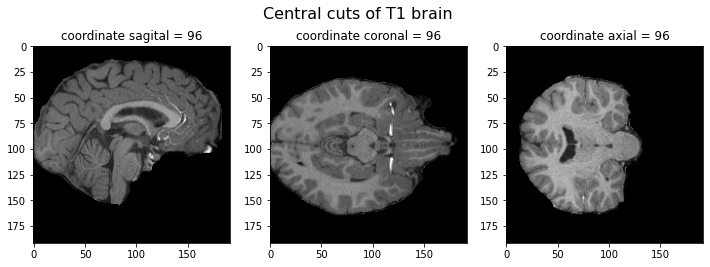

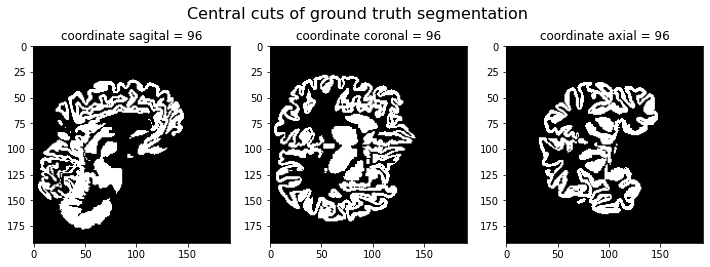

In [4]:
plot_central_cuts(img, 'T1 brain')
plot_central_cuts(seg, 'ground truth segmentation')

# Preprocessing data

In [5]:
histogram_landmarks_path = 'landmarks/fcd_train_data_landmarks.npy'
landmarks = np.load(histogram_landmarks_path)


training_transform = Compose([
    HistogramStandardization(landmarks={'MRI': landmarks}),
    ZNormalization(masking_method=ZNormalization.mean),
    CropOrPad((200, 200, 200)),
])

validation_transform = Compose([
    HistogramStandardization(landmarks={'MRI': landmarks}),
    ZNormalization(masking_method=ZNormalization.mean),
    CropOrPad((200, 200, 200)),
])

# Splitting data into train and test parts 

In [6]:
cv = ShuffleSplit(n_splits = 1,  test_size = 0.3, random_state = 42)
cv_splits = list(cv.split(X=np.arange(len(fcd_pirogov_seg_data)), y=fcd_pirogov_seg_data.target))

# Creating dataloaders for model 

In [7]:
training_loader, validation_loader = get_loaders(fcd_pirogov_seg_data, cv_splits[0],
        training_transform = training_transform,
        validation_transform = validation_transform, input_type = 'T1')

Training set: 926 subjects
Validation set: 398 subjects
Input type is T1


# Getting model and optimizer 

In [8]:
torch.cuda.empty_cache()

In [9]:
!nvidia-smi

Mon Mar 22 11:52:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
|  0%   30C    P8     9W / 280W |    577MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
|  0%   36C    P2   168W / 280W |   7953MiB / 11178MiB |     99%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [10]:
torch.cuda.set_device(2)
torch.cuda.current_device()

2

In [11]:
model, optimizer, scheduler = get_model_and_optimizer(device, out_channels_first_layer = 8)
model.load_state_dict(torch.load('weights/all_images_augm_seg_epoch_7.pth'))

<All keys matched successfully>

Epoch 4 of 5 took 15389.695s
  training loss (in-iteration): 	0.041444
  validation loss: 			0.130139


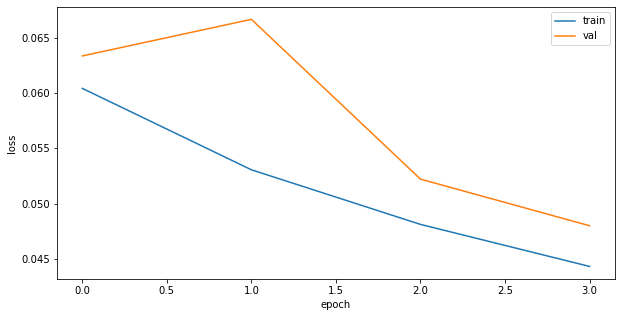

 85%|████████▌ | 790/926 [42:12<07:15,  3.21s/it]

In [ ]:
torch.cuda.empty_cache()

if experiment:
    experiment.set_name("Additional training, whole images test, augm")

training_params =  {
    'num_epochs': 5, 
    'training_loader': training_loader, 
    'validation_loader': validation_loader,
    'model': model, 
    'optimizer': optimizer,
    'scheduler': scheduler,
    'ratio' : False,
    'experiment':experiment,
    'weights_stem':'all_images_augm_seg_add_training',
    'verbose':True,
    'save_epoch':1,
    'loss_type': 'dice',
    'task': 'T1_to_seg'
}

train(**training_params)

# Evaluating results

In [11]:
model, optimizer, scheduler = get_model_and_optimizer(device, out_channels_first_layer = 8)
model.load_state_dict(torch.load('weights/all_images_augm_seg_epoch_7.pth'))

<All keys matched successfully>

In [14]:
model.eval()

dice_scores = []
iou_scores = []
average_distances_gt_to_pred = []
average_distances_pred_to_gt = []

for batch in tqdm(validation_loader):
    inputs, targets = prepare_batch(batch, device, task = 'T1_to_seg')
    with torch.no_grad():
        logits = forward(model, inputs)
        probabilities = F.softmax(logits, dim = CHANNELS_DIMENSION)
        prediction = probabilities.argmin(dim = 1)[0]
        ground_true  = targets[0,0,:]
        
    dice_scores.append((get_dice_score(targets, probabilities)*torch.tensor([1, 0]).float().to(device)).sum().cpu().detach().numpy())
    iou_scores.append(get_iou_score(prediction.cpu().detach().numpy(), ground_true.cpu().detach().numpy()))
    
    average_distance_gt_to_pred, average_distance_pred_to_gt = compute_average_surface_distance(
        compute_surface_distances(
        ground_true.cpu().numpy().astype(np.uint8),
        prediction.cpu().numpy(), 
        spacing_mm=(1,1,1)
        )
    )
    average_distances_gt_to_pred.append(average_distance_gt_to_pred)
    average_distances_pred_to_gt.append(average_distance_pred_to_gt)
    
print('Mean dice score = ', np.mean(dice_scores))
print('Mean IoU score = ', np.mean(iou_scores))
print('Mean average distance gt to prediction = ', np.mean(average_distances_gt_to_pred))
print('Mean average distance prediction to gt = ', np.mean(average_distances_pred_to_gt))

100%|██████████| 398/398 [35:53<00:00,  5.41s/it]

Mean dice score =  0.9123747
Mean IoU score =  0.8417598776353111
Mean average distance gt to prediction =  0.22791559252517157
Mean average distance prediction to gt =  0.17395265403912388


In [13]:
model.eval()
dice_scores = []

batch = next(iter(validation_loader))
inputs, targets = prepare_batch(batch, device, task = 'T1_to_seg')
with torch.no_grad():
    logits = forward(model, inputs)
    probabilities = F.softmax(logits, dim = CHANNELS_DIMENSION)
pred = probabilities.argmin(dim = 1)[0]
seg  = targets[0,0,:]

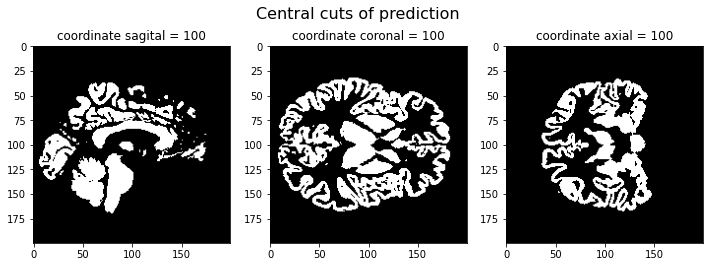

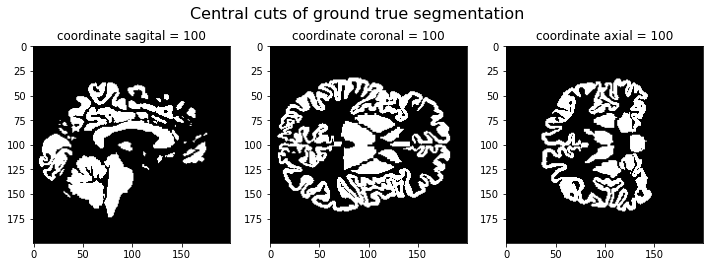

In [14]:
plot_central_cuts(pred.cpu().detach().numpy(), 'prediction')
plot_central_cuts(seg.cpu().detach().numpy(), 'ground true segmentation')

# Saving predictions for all T1 images

In [25]:
training_set = get_torchio_dataset(
    list(fcd_pirogov_seg_data.img_files.values), 
    list(fcd_pirogov_seg_data.img_seg.values),
    training_transform)

training_loader = torch.utils.data.DataLoader(
    training_set, batch_size = 1)

model.eval()
path = '../datasets/fcd_classification_bank/predictions/'
lst = glob.glob(os.path.join(path,'*nii*')) 

for i, batch in enumerate(training_loader):
    img_path = fcd_pirogov_seg_data.img_files.values[i]
    inputs, targets = prepare_batch(batch, device)
    with torch.no_grad():
        logits = forward(model, inputs)
        probabilities = F.softmax(logits, dim = CHANNELS_DIMENSION)
        pred = probabilities.argmin(dim = 1)[0].cpu().detach().numpy()

        img1 = nib.load(img_path)
        affine = img1.affine

        new_image = nib.Nifti1Image(pred, affine)
        nib.save(new_image, path + img_path.split('/')[-1].split('_norm')[0] + '.nii.gz')

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
